# Tips for Training Neural Network

In this notebook, we are going to discuss some tips for training robust neural network. This notebook will not focus on code but rather the intuition behind these tips. All the methods below can be easily conducted through Keras API. We will try to cover the implementation in simple examples. For detailed instruction please take a look at the well-written Keras documentation.

---

## Notebook Setting

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU, MaxoutDense
from keras.optimizers import SGD, Adam, Adagrad, RMSprop, Nadam
from keras.utils import np_utils
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping

## Quick Example with MNIST

In [27]:
def load_data():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train = X_train.reshape(-1, 28*28)
    X_train = X_train.astype('float')
    X_test = X_test.reshape(-1, 28*28)
    X_test = X_test.astype('float')
    
    # Convert class vectors to binary class matrices
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    X_train = X_train
    X_test = X_test
    
    # X_test = np.random.normal(X_test)
    X_train = X_train / 255 # normalize the pixel
    X_test = X_test / 255 # normalize the pixel
    return((X_train, y_train),(X_test, y_test))

In [28]:
if __name__ == '__main__':
    # load training data and testing data
    (x_train, y_train), (x_test, y_test) = load_data()
    # define network structure
    model = Sequential()

    model.add(Dense(input_dim=28 * 28, units=300, activation='sigmoid'))
    model.add(Dense(units=300, activation='sigmoid'))
    model.add(Dense(units=10, activation='softmax'))

    # set configurations
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(), metrics=['accuracy'])

    # train model
    history = model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.3)

    # evaluate the model and output the accuracy
    result_train = model.evaluate(x_train, y_train)
    result_test = model.evaluate(x_test, y_test)
    print('\n')
    print('----------Model Result----------')
    print('Train Acc:', result_train[1])
    print('Test Acc:', result_test[1])

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 4s 89us/step - loss: 2.2957 - accuracy: 0.1858 - val_loss: 2.2568 - val_accuracy: 0.1724
Epoch 2/20
42000/42000 [==============================] - 3s 77us/step - loss: 2.2319 - accuracy: 0.3602 - val_loss: 2.2090 - val_accuracy: 0.3564
Epoch 3/20
42000/42000 [==============================] - 4s 88us/step - loss: 2.1789 - accuracy: 0.4617 - val_loss: 2.1501 - val_accuracy: 0.3785
Epoch 4/20
42000/42000 [==============================] - 3s 77us/step - loss: 2.1171 - accuracy: 0.5137 - val_loss: 2.0862 - val_accuracy: 0.4045
Epoch 5/20
42000/42000 [==============================] - 4s 86us/step - loss: 2.0426 - accuracy: 0.5424 - val_loss: 2.0008 - val_accuracy: 0.4836
Epoch 6/20
42000/42000 [==============================] - 4s 90us/step - loss: 1.9544 - accuracy: 0.5482 - val_loss: 1.9052 - val_accuracy: 0.4924
Epoch 7/20
42000/42000 [==============================] - 4s 93us/st

From the result above, we can see that deep learning is really powerful! You don't need to anything and you can have a quite robust results(compared to random guesses). However, in more complicated dataset we can encounter some difficult problems, and our deep learning model may not perform well as we intend. Below we will discuss some common tips to boost the result of the Neural Network.

---

# Tips for Training Neural Network

In classic machine learning algorithms, **overfitting is a common problem** since the model overfits training data and results in awful performance on testing data. This is because **the model 100% fits the training data**. Therefore, it cannot adjust to noise or bias between training and testing dataset. 

One unique property in Neural Network is that **the training data will not 100% fit the neural network itself**. The weights and bias are updated through backpropagation, but it is not gauranteed (and is often not the case) that the neural network can 100% fit the network structure. Yes, the accuracy will increase when the backpropagation algorithm is conducted for several epochs. However, you can hardly reach a 100% training accuracy given the noisy data.


Therefore, when training neural network, there are two sub-processing in evaluating the goodness of the model structure.

1. Evaluate the result on **training** data.
2. Evaluate the result on **testing** data.

**It's possible to have good training result but bad testing result**, which is **overfitting**. In the meantime, it is also likely that the neural network works quite well on testing data but not on training data. Worse yet, the model can perform bad on both training and testing data. For different scenario, different approaches are introduced, and in the following section we will discuss some tips for training neural network as well as how to deal with such problems.

---

# Improving Your Result on Training Data

## Choose Another Activation Function

<img src="pic/activationfunc.png" width=600>

Activation Function is the tranformation function at each node that transform inputs to outputs. The above is a subset of popular activation function out there. As discussed at the beginning of the notebook, sigmoid function is the first known activation function used in Neural Network structrue. The sigmoid function has recently fallen out of favor and it is rarely used nowadays, since it comes with major pitfalls that can limit or even damage the performance of the neural network.

1. **Sigmoids saturate and kill gradients**. Sigmoid function will saturate at either 0 or 1, where the gradient at these two regions is almost zero. Therefore, during backpropagation the updated gradiant (~0) can kill the gradients and thus cannot update the weights connected to that neurons. Worse yet, it can also cause problems if the weight initialization is not done properly (the neurons can be killed at the first epoch.) This problem is also known as the **Vanishing Gradient Problem**. 


2. **Sigmoid outputs are not zero-centered**. The output of the sigmoid function is always positive, which is a undesirable property given the fact that the update through backpropagation will be dependent on the gradient of whole function. 


**tanh** activation function is used to resolve the non-zero-centered nature for the **sigmoid** activation function, so the **tanh** non-linearity activation function is preferred over **sigmoid**. However, it also comes with the problem of **Vanishing Gradient Problem**.

### The Vanishing Gradient Problem

<img src="pic/vgp.png" width=600>

The best way to deal with Vanishing Gradient Problem is to change your activation function from **Sigmoid** to **Rectified Linear Unit (ReLU)**.

Before we dive into the ReLU activation function, let's first discuss why Vanishing Gradient Problem is a difficult but important problem. The problem of vanishing gradients arises due to the nature of the backpropagation optimization. Gradients tend to **vanish** as we keep on moving backward, as the gradient is getting smaller and smaller. Thus, the neurons in earlier layers will learn very slowly compared to neurons in later layers. In some cases, the sets of weights in the neural network might even not be updated as thus remain almost random.

Thus, **Vanishing Gradient Problem** results in a decrease in the prediction accuracy of the model and take a long time to train a model.

### ReLU

The **ReLU (Rectified Linear Unit)** is recently proposed and is a highly regarded activation function that solves the **Vanishing Gradient Problem**. It computes the function $f(𝑥)=max(0,𝑥)$. There are several pros and cons to using the ReLUs:

**Pros**

1. **ReLU accelarate convergence**. It is found empirically to accelerate the time needed for convergence compared to the **sigmoid** and **tanh** activation function. This quickness can be attribute to the linearity as well as the non-saturating nature. 

2. **Computationally efficient**. Compared to **Sigmoid** and **tanh** that takes on the calculation of **exp(x)**, the computation of Max is more efficient and thus can get the solution faster.

**Cons**

1. **Dying Neuron Problem**. If at any moment the gradient of a certain neuron is zero, that neuron will be killed from then on and never activate again. That is, the ReLU units can irreversibly die during training since they can get knocked off the data manifold. For example, you may find that as much as 40% of your network can be "dead" (i.e. neurons that never activate across the entire training dataset) if the learning rate is set too high. With a proper setting of the learning rate this is less frequently an issue.


<img src="pic/leaky.png">


Due to this undesirable nature, **Leaky ReLU** is proposed to fix the **dying neuron** problem. Instead of the function being zero when x < 0, a leaky ReLU will instead have a small negative slope. Therefore, the **dying neuron problem** can be fixed. There is another variant called **Parametric ReLU**, which set the slope to another variable that can be learned by the neural network through back propagation.

### Maxout

Another activation, **Maxout, is proposed to be flexible, learnable activation function**. The Maxout activation is, in fact, a generalization of the ReLU and the leaky ReLU functions. The Maxout activation function is formulated below:

$$max(w_1^T + b_1, w_2^T + b_2)$$

**Pros**

1. It is a piecewise linear function that returns the maximum of the inputs. Thus, it can take any piecewise linear convex function and doesn't necessarily have to be the format above. For example, you can compare three or even four in one group at a time.

<img src="pic/max2.png" width=600>

2. Both ReLU and leaky ReLU are special cases of the Maxout activation function. Thus, it enjoys all the benefits of a ReLU unit (linearity, no saturation) and does not have its drawbacks (dying neuron problem).

**Cons**

1. Using the Maxout activation function requires more parameters to be updated for each neuron, which can take more time to train the entire neural network.


### Kernal Activation Functions

Kernel Activation Function (Kafnets) is a newly proposed activation functions in the paper **[Kafnets: kernel-based non-parametric activation functions for neural networks](https://arxiv.org/abs/1707.04035)**. According to this paper,  neural networks are generally built by interleaving (adaptable) linear layers with (fixed) nonlinear activation functions. In this paper, the author introduces a novel family of flexible activation functions that are based on an inexpensive kernel expansion at every neuron. Now **kafnets** can be implemented through Keras, Tensorflow, and PyTorch. For implementation please see the github repository **[Kernel Activation Functions](https://github.com/ispamm/kernel-activation-functions)**

### Best Practice

Below is the some guidelines for choosing the activation function.

1. Use **ReLU** in hidden layer activation, but be careful with the learning rate and monitor the fraction of dead units. If ReLU is giving problems. Try **Leaky ReLU or Maxout**.

2. Normalize and standardize the input data in advance. It can help achieve higher validation accuracy and decrease the training time.

3. Don't use **sigmoid** and **tanh** activation function as the **Vanishing Gradient Problem** can kill you entire network structure.

---

## Adaptive Gradient Descent Algorithms / Adaptive Learning Rate

Traditional gradient descent sets a constant learning rate for the entire neural network. By setting the batch size, in fact the model is using mini-batch / stochastic gradient descent to update each weight. Learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. A value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

In Keras, learning rate optimizer is configured through the following API, the **optimizer** hyperparameter in particular:

```python
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(), metrics=['accuracy'])
```

There are lots of different learning rate that in fact changes in response to the learning process. For example, the optimizer above, Adam(), is a well-regarded optimizer that is widely used today.

---

### Stochastic Gradient Descent with Momentum

The most basic optimizer is **SGD()**, which takes in the parameter **learning rate** and **momentum**. Momentum is a technique that takes the previous movement into account. A typical choice of momentum is between 0.5 to 0.9.

Without momentum, the parameter is updated as follows:

\begin{align}
\theta^1 = \theta^0 - \eta \nabla L(\theta^0) \\
\theta^2 = \theta^1 - \eta \nabla L(\theta^1) \\
... \\
\nabla L(\theta^t) = 0 \\
\end{align}


With momentum, the parameter is updated as follows:

start at point $\theta^0$, movement $v^0 = 0$, then

\begin{align}
v^1 = \lambda v^0 - \eta \nabla L(\theta^0) \\
\theta^1 = \theta^0 + v^1 \\
v^2 = \lambda v^1 - \eta \nabla L(\theta^1) \\
\theta^2 = \theta^1 + v^2 \\
... \\
\end{align}

That is, movement is not only based on gradient but also the previous movement. With momentum, it almost always work better than normal SGD without momentum.

```python
from keras.optimizers import SGD
model.compile(..., optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))
```

**Nesterov Momentum** is a slightly different version of momentum update that utilize the **look ahead gradient** instead of current gradient. It is a different version of the momentum method which has stronger theoretical converge guarantees for convex functions. You can call it by setting `nesterov=True`. 

<img src="pic/nesterov.jpeg">

The image above illustrates the difference between normal momentum and nesterov momentum. In practice, it works slightly better than standard momentum.

---

### Adagrad

Adagrad is the abbreviation of **Adaptive Gradient Descent**. It's a gradient-based optimization method that adapts the learning rate to the parameters. It gives smaller updates (low learning rates) for parameters associated with frequently occurring features, and larger updates (high learning rates) for parameters associated with infrequent features. In short, for Adagrad every parameter has its own learning rate.

For normal stochastic gradient descent, the parameter is updated as below:

\begin{align}
\theta^{t+1} = \theta^{t} - \eta \nabla L(\theta^0) \\
\end{align}

In adagrad, the parameter is updated as below.

\begin{align}
\theta^{t+1} = \theta^{t} - \frac{\eta}{\sqrt{\sum_{i=0}^t (g^i)^2}} \nabla L(\theta^0) \\
\end{align}

One of Adagrad's main benefits is that it eliminates the need to manually tune the learning rate. In most implementations, we only need to set a default value of 0.01 or so.

One of its weakness lies in the denominator term. Since every added term is positive, the acucumulated sum keeps growing. Thus, this can cause the learning rate to shrink to an extremely small value, which at some point the parameter is no longer able to upadte.

---

### RMSProp

RMSProp (Root Mean Square propagation) is a method proposed by Geoff Hinton in this [lecture](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf). The central idea of RMSprop is keep the moving average of the squared gradients for each weight. It introduces a new parameter $\alpha$. If $\alpha$ is small, you tend to believe the new gradient more than the previous ones, and vice versa. The mathematical formulation for RMSProp can be shown below.

\begin{align}
\theta^1 = \theta^0 - \frac{\eta}{\sigma^0} g^0\\
\sigma^0 = g^0 \\
\theta^2 = \theta^1 - \frac{\eta}{\sigma^1} g^1\\
\sigma^1 = \sqrt{\alpha (\sigma^0)^2 + (1 - \alpha) (g^1)^2} \\
... \\
\theta^{t+1} = \theta^t - \frac{\eta}{\sigma^t} g^t\\
\sigma^t = \sqrt{\alpha (\sigma^{t-1})^2 + (1 - \alpha) (g^t)^2} \\
\end{align}


In Hinton's lecture, he suggests that $\alpha$ to be set at 0.9, meaning that previous cumulative gradients are placing more emphasis. This value should be tuned manually in order to get a better result.

---

### Adam

Adam (Adaptive Moment Estimation) is another method that computes adaptive learning rates for the parameeter. In essence, it's the combination of momentum and RMSprop, while introducting a new bia-correction term. It stores an exponentially decaying average of past squared gradeints, similar to RMSprop, and keeps the exponentially decaying average of the past gradients, similar to momentum. 

<img src="pic/ADAM.png" width=500>

---


### Best Practice

Adam has been proved to be the stable and safest choice when it comes to optimizers. Below is an interesting post that experiments lots of combinations for learning rates and optimizers: [How to pick the best learning rate for your machine learning project](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2). In short, **choose Adam if you can**!

---

# Improving Your Result on Testing/Validation Data

## Early Stopping

In general, total loss for both testing and training data will decrease after training more epochs. However, as the loss for training set continue to decrease, loss for testing data might at some point starts to increase. This often happens due to the fact that we are optimizing the parameter by evaluating through training data, and the optimal parameters for training set might not be those for the testing data. 

<img src="pic/early_stopping.png">

It seems reasonable to stop training at the point when the minimal validation error is achieved. Training the model any further only leads to overfitting. Thus, Early Stopping is a technique to stop the neural network training when the validation data has the smallest total loss even if the loss for the training data is still decreasing. **In Keras, you can feed the validation set into keras model and use the following API to find implement EarlyStopping**.

```python
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, min_delta=1, baseline=0.4)
```

This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process. 

**Monitor**: The performance metrics you want to monitor in order to find the trigger of early stopping.

**Mode**: whether you are minimizing or maximizing the monitored metrics. By default, mode is set to `auto`, which knows that you want to minimize loss or maximize accuracy.

Below are other optional parameters you can pass in:

**Patience**: The size of delays for early stopping.

In some cases the first sign of no improvement might not be the best time to stop training. This is because the model might encounter a plateau of no improvement, or it might just be trapped in a local optimum. Thus, we can deal with this issue by adding a **delay** parameter to the trigger in terms of the number of epochs on which we would like to see no improvement.

**min_delta**: The minimum acceptable definition of **improvement**.

In some cases there might be a fractional improvement that doesn't necessarily mean anything to you. You can set the minimum amount of improvement to be considered as improvement.

**baseline**: threshold for stopping the training process.

For more information about how early stopping can benefit your neural network, check out this wonderful post: [Use Early Stopping to Halt the Training of Neural Networks At the Right Time](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

---

## Regularization

What regularization can do to neural network is similar to other machine learning models. In machine learning, regularization penalizes the coefficients by shrinking the coefficeints toward zero. In deep learning, it actually penalizes the weight matrices of the nodes. However, in deep learning the problem is a little more complex.

Say that the regularization coefficient is so high that some of the weight matrices are nearly equal to zero.

<img src="pic/regu.png">

From the above image we can see that the original complex network structure shrinks to a much simpler linear network and thus slightly underfits of the training data. Such a large value of the regularization coefficient can ruin your model. Thus, the regularization coefficient is another parameter that the training process needs to take care of.


For L2 Regularization,

$$L'(\theta) =  L(\theta) + \lambda\frac{1}{2}\left \| \theta \right \|_2,$$

where

$$ \left \| \theta \right \|_2 = (w_1)^2 + (w_2)^2 + ...$$


Regularization works by adding an extra penalty term to the orignial loss function. $\lambda$ is the coefficient parameter for the regularization term that needs to be optimized through the training process for better results. L2 Regularization is also known as **Weight Decay**, as it forces the weights to decay towards zero (but not exactly zero). L1 Regularization, on the other hands, can actually forces the weight to be zero. Therefore, L1 regularization is useful if you want to compress the model to a simpler format.


Gradient: $$\frac{\partial L' }{\partial w} = \frac{\partial L }{\partial w}  + \lambda w $$

Update: $$w^{t+1} \rightarrow  w^t - \eta \frac{\partial L'}{\partial w} = w^t - \eta (\frac{\partial L}{\partial w} + \lambda w^t) = (1-\eta \lambda)w^t - \eta \frac{\partial L}{\partial w}$$


The difference between L1 and L2 Regularization is that the result for L1 regularization is sparse -- you will end up having some zeros and some large numbers. For L2 regularization, you will reduce the number to roughly the same scale -- all reduce to a certain small number. Therefore, choosing between L1 and L2 depends on the context of the problem.

You can implement regularization through keras by setting one simple parameter:

```python
from keras import regularizers
    model.add(Dense(units=300, activation='relu'), kernel_regularizer=regularizers.l2(0.01))

```

Frankly speaking, regulation doesn't help as much as other methods. Therefore, in lots of neural network implementation you hardly see the usage of regularization. People often tends to implement **Dropout** more often compared to **Regularization**.

## Dropout

**Dropout** is a technique used to prevent a model from **overfitting** and is a special method specifically designed for neural network. .

<img src="pic/dropout.png" width=500>

**While training,**

Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

Dropout occurs before each iteration that updates the parameters. First, it randomly select p% of the neurons and set those to 0 at each update of the training phase. Thus, the structure of the network is changed. Then, the model uses this new network for training. For each mini-batch, we resample the dropout neurons.

Note that if you use dropout technique, the performance on training dataset will be worse than normal. However, the dropout technique is intentionally designed to perform worse on training data but better on testing data.

**While testing,**

Note that you should not conduct dropout on the testing process. You should follow the rules below.

* If the dropout rate at training is p%, all the weights should time (1-p)%

* Assume that the dropout rate is 50%, if weight w = 1 when training, set w = 0.5 fore testing.

This will be done automatically by current packages. But.. Why is that?

<img src="pic/dropout2.png" width = 500>

To conclude, what dropout does is that at every iteration, it randomly selects some nodes and removes them along with all of their incoming and outgoing connections. Therefore, each iteration will have a different set of nodes. It can also be thought of as an ensemble technique in machine learning. Namely, **dropout can be seen as a kind of ensemble method in neural networks**.

<img src="pic/dropout3.png" width = 500>

In keras, we can implement dropout as a layer. See the following code:

```python
    model = Sequential()
    model.add(Dense(input_dim=28 * 28, units=300, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=300, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=10, activation='softmax'))
```

The parameter that is fed into the Dropout layer is the percentage of nodes being dropped. We can tune the parameter better by using GridSearch.

---

## Re-do the MNIST Dataset

### Model 2: Add additional layers, regularizers, and dropouts.

In [34]:
if __name__ == '__main__':
    # load training data and testing data
    (x_train, y_train), (x_test, y_test) = load_data()
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    # define network structure
    model = Sequential()

    model.add(Dense(input_dim=28 * 28, units=300, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(units=300, activation=LeakyReLU(),kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(units=10, activation='softmax'))

    # set configurations
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(), metrics=['accuracy'])

    # train model
    history2 = model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.3)

    # evaluate the model and output the accuracy
    result_train = model.evaluate(x_train, y_train)
    result_test = model.evaluate(x_test, y_test)
    print('\n')
    print('----------Model Result----------')
    print('Train Acc:', result_train[1])
    print('Test Acc:', result_test[1])

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 8s 186us/step - loss: 3.4893 - accuracy: 0.7270 - val_loss: 1.2714 - val_accuracy: 0.7989
Epoch 2/20
42000/42000 [==============================] - 7s 162us/step - loss: 1.0538 - accuracy: 0.7946 - val_loss: 0.9643 - val_accuracy: 0.7596
Epoch 3/20
42000/42000 [==============================] - 7s 158us/step - loss: 0.8900 - accuracy: 0.7970 - val_loss: 0.9308 - val_accuracy: 0.7443
Epoch 4/20
42000/42000 [==============================] - 6s 151us/step - loss: 0.8308 - accuracy: 0.8033 - val_loss: 0.8294 - val_accuracy: 0.7927
Epoch 5/20
42000/42000 [==============================] - 6s 150us/step - loss: 0.8068 - accuracy: 0.8058 - val_loss: 0.8801 - val_accuracy: 0.7564
Epoch 6/20
42000/42000 [==============================] - 7s 162us/step - loss: 0.7914 - accuracy: 0.8094 - val_loss: 0.7746 - val_accuracy: 0.8009
Epoch 7/20
42000/42000 [==============================] - 6s 1

### Model 3: Take out the additional layer; simplify the model structure

In [46]:
if __name__ == '__main__':
    # load training data and testing data
    (x_train, y_train), (x_test, y_test) = load_data()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    # define network structure
    model = Sequential()

    model.add(Dense(input_dim=28 * 28, units=300, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=300, activation=LeakyReLU(),kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(units=10, activation='softmax'))

    # set configurations
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(), metrics=['accuracy'])

    # train model
    history3 = model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.3, callbacks=[es])

    # evaluate the model and output the accuracy
    result_train = model.evaluate(x_train, y_train)
    result_test = model.evaluate(x_test, y_test)
    print('\n')
    print('----------Model Result----------')
    print('Train Acc:', result_train[1])
    print('Test Acc:', result_test[1])

/Users/ytchou/opt/miniconda3/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 6s 145us/step - loss: 1.7353 - accuracy: 0.7654 - val_loss: 0.8631 - val_accuracy: 0.7879
Epoch 2/20
42000/42000 [==============================] - 5s 123us/step - loss: 0.6415 - accuracy: 0.8347 - val_loss: 0.5261 - val_accuracy: 0.8487
Epoch 3/20
42000/42000 [==============================] - 5s 121us/step - loss: 0.5021 - accuracy: 0.8502 - val_loss: 0.5083 - val_accuracy: 0.8422
Epoch 4/20
42000/42000 [==============================] - 7s 166us/step - loss: 0.4584 - accuracy: 0.8581 - val_loss: 0.4674 - val_accuracy: 0.8498
Epoch 5/20
42000/42000 [==============================] - 7s 158us/step - loss: 0.4340 - accuracy: 0.8632 - val_loss: 0.4320 - val_accuracy: 0.8602
Epoch 6/20
42000/42000 [==============================] - 6s 150us/step - loss: 0.4229 - accuracy: 0.8660 - val_loss: 0.4535 - val_accuracy: 0.8534
Epoch 7/20
42000/42000 [==============================] - 5s 1

### Model 4: Try EarlyStopping. Change Adam optimizer to Nadam.

In [56]:
if __name__ == '__main__':
    # load training data and testing data
    (x_train, y_train), (x_test, y_test) = load_data()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
    # define network structure
    model = Sequential()

    model.add(Dense(input_dim=28 * 28, units=300, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=300, activation=LeakyReLU(),kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(units=10, activation='softmax'))

    # set configurations
    model.compile(loss='categorical_crossentropy',
                  optimizer=Nadam(), metrics=['accuracy'])

    # train model
    history4 = model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.3, callbacks=[es])

    # evaluate the model and output the accuracy
    result_train = model.evaluate(x_train, y_train)
    result_test = model.evaluate(x_test, y_test)
    print('\n')
    print('----------Model Result----------')
    print('Train Acc:', result_train[1])
    print('Test Acc:', result_test[1])

/Users/ytchou/opt/miniconda3/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 6s 149us/step - loss: 1.3973 - accuracy: 0.7551 - val_loss: 1.4336 - val_accuracy: 0.5368
Epoch 2/20
42000/42000 [==============================] - 5s 122us/step - loss: 0.5670 - accuracy: 0.8271 - val_loss: 2.5393 - val_accuracy: 0.5442
Epoch 3/20
42000/42000 [==============================] - 5s 124us/step - loss: 0.5177 - accuracy: 0.8401 - val_loss: 0.8234 - val_accuracy: 0.7471
Epoch 4/20
42000/42000 [==============================] - 5s 124us/step - loss: 0.4619 - accuracy: 0.8519 - val_loss: 0.5199 - val_accuracy: 0.8280
Epoch 5/20
42000/42000 [==============================] - 5s 129us/step - loss: 0.4354 - accuracy: 0.8585 - val_loss: 0.5497 - val_accuracy: 0.8341
Epoch 6/20
42000/42000 [==============================] - 6s 136us/step - loss: 0.4146 - accuracy: 0.8664 - val_loss: 0.7807 - val_accuracy: 0.7767
Epoch 7/20
42000/42000 [==============================] - 5s 1

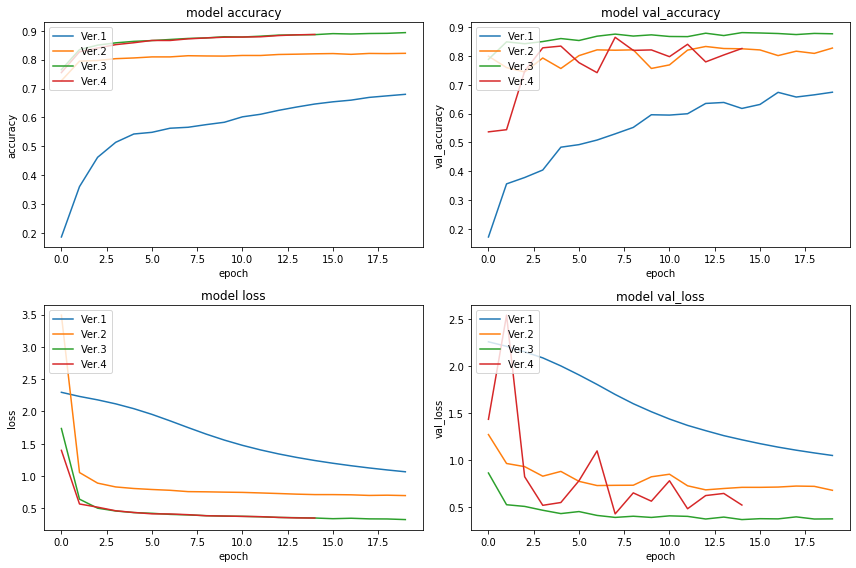

In [71]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history4.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Ver.1', 'Ver.2','Ver.3','Ver.4'], loc='upper left')

plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model val_accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['Ver.1', 'Ver.2','Ver.3','Ver.4'], loc='upper left')

plt.subplot(223)
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Ver.1', 'Ver.2', 'Ver.3','Ver.4'], loc='upper left')

plt.subplot(224)
plt.plot(history.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.title('model val_loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['Ver.1', 'Ver.2', 'Ver.3','Ver.4'], loc='upper left')
plt.tight_layout()
plt.show()

From the above trails, we can get some intuitions:

1. Deeper neural network doesn't necessarily increase the performance. Finding the best network structure requires trial and error.

2. There is no optimal optimizer. You can see that Ver.4 (Nadam) performs worse than Ver.3 (Adam), though we know that Nesterov Momentum in practice performs better than normal momentum. Thus, it again requires lots of trial and error!

3. For a new problem, you can experiment in the following orders:
    - Use Stochastic Gradient Descent (SGD) to find the better neural network structure. Although the accuracy may not be the best cases, this method can help you find the better structure. The structure includes dropout and regularization.
    - After you find a good model structure, try chaning the optimizer from SGD to robust ones, for example Adam and Nadam. Again, you need to experiment in order to find the one more suitable for your problem.
    - Plot out the result using the History callback to see if you need further modification.

## **Reference:**

[Stanford CS231n](http://cs231n.github.io/neural-networks-1/)

[[Medium] Complete Guide of Activation Functions](https://towardsdatascience.com/complete-guide-of-activation-functions-34076e95d044)

[[Medium] Introduction to Different Activation Functions for Deep Learning](https://medium.com/@shrutijadon10104776/survey-on-activation-functions-for-deep-learning-9689331ba092)

[[Medium] Stochastic Gradient Descent with momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d)

[[StackExchange] **Phylliida's Answer** on Comprehensive list of activation functions in neural networks with pros/cons](https://stats.stackexchange.com/questions/115258/comprehensive-list-of-activation-functions-in-neural-networks-with-pros-cons)

[Display Deep Learning Model Training History in Keras](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

[Understand the Impact of Learning Rate on Neural Network Performance](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)

[An overview of gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/index.html)

[[Medium] How to pick the best learning rate for your machine learning project](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2)

[Use Early Stopping to Halt the Training of Neural Networks At the Right Time](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

[An Overview of Regularization Techniques in Deep Learning](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/)